# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 3: Equity Portfolio VaR/ES and Counterparty Risk

DCF_t0_ti: [0.99737277]
Final Dates: [Date(2,2,2023), Date(3,2,2023), Date(9,2,2023), Date(2,3,2023), Date(3,4,2023), Date(15,6,2023), Date(21,9,2023), Date(20,12,2023), Date(20,3,2024), Date(20,6,2024), Date(19,9,2024), Date(18,12,2024), Date(3,2,2025), Date(2,2,2026), Date(2,2,2027), Date(2,2,2028), Date(2,2,2029), Date(4,2,2030), Date(3,2,2031), Date(2,2,2032), Date(2,2,2033), Date(2,2,2034), Date(2,2,2035), Date(4,2,2036), Date(2,2,2037), Date(2,2,2038), Date(2,2,2039), Date(2,2,2040), Date(4,2,2041), Date(3,2,2042), Date(2,2,2043), Date(2,2,2044), Date(2,2,2045), Date(2,2,2046), Date(4,2,2047), Date(3,2,2048), Date(2,2,2049), Date(2,2,2050), Date(2,2,2051), Date(2,2,2052), Date(3,2,2053), Date(2,2,2054), Date(2,2,2055), Date(2,2,2056), Date(2,2,2057), Date(4,2,2058), Date(3,2,2059), Date(2,2,2060), Date(2,2,2061), Date(2,2,2062), Date(2,2,2063), Date(4,2,2064), Date(2,2,2065), Date(2,2,2066), Date(2,2,2067), Date(2,2,2068), Date(4,2,2069), Date(3,2,2070), Date(2,2,2071), Date(2,2,

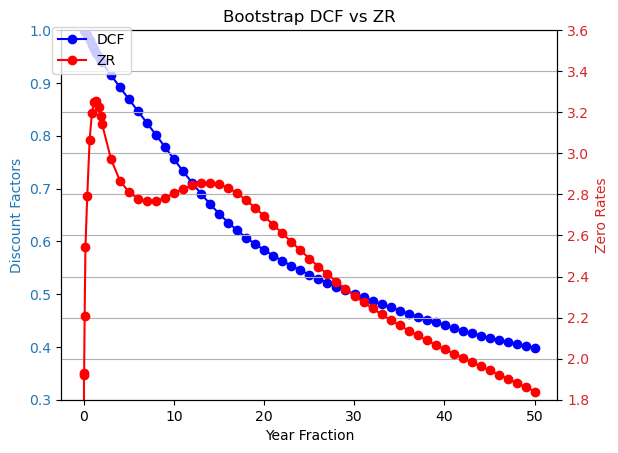

In [1]:
# Importing libraries and loading data
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from utilities.ex1_utilities import (
    business_date_offset,
    year_frac_act_x,
    get_discount_factor_by_zero_rates_linear_interp,
    bootstrap,
    date_series,
)
from utilities.ex3_utilities import (
    gaussian_var_es,
    hs_var_es,
    principal_component_analysis,
    plausility_check,
    black_scholes_option_pricer,
    simulated_stock_MC,
    cliquet_option_pricer,
)

# !!! IMPORT PRICES AND TICKERS DATA !!!
prices = pd.read_csv('sx5e_underlyings.csv',index_col='Date',parse_dates=True) # sx5e_underlyings.csv
tickers_df = pd.read_csv('ticker_details.csv',usecols=[1,2]) # ticker_details.csv

filename = "MktData_CurveBootstrap.xls"
dates, rates, discount_factors = bootstrap(filename,0)

In [3]:
# Parameters
date = pd.Timestamp(2020, 1, 31)
alpha = 0.95  # Significance level

log_returns = np.log(prices).diff()
log_returns.bfill(inplace=True)

In [4]:
# Case Study 1 - Q1: Compute daily VaR and ES with a 4y estimation using the dataset provided via Gaussian
# parametric approach.

time_horizon1 = 4  # In years
ptf_notional = 25e6  # In euros
start_date1 = date- relativedelta(years=time_horizon1)

# !!! COMPLETE APPROPRIATELY !!!
portfolio1_stocks = ['BMWG.DE','BNPP.PA','DANO.PA','NOKIA.HE','TTEF.PA']
weights = pd.Series([0.2 ,0.2 ,0.2 ,0.2 ,0.2],index=portfolio1_stocks)

mu = log_returns.loc[start_date1:date, weights.index].mean()
sigma = log_returns.loc[start_date1:date, weights.index].cov()
VaR_1, ES_1 = gaussian_var_es(mu, sigma, alpha, weights, ptf_notional)
print(f"Case Study 1 - Q1: Gaussian VaR: €{VaR_1:,.2f}, ES: €{ES_1:,.2f}")

Case Study 1 - Q1: Gaussian VaR: €412,698.59, ES: €517,873.58


In [5]:
# Case Study 1 - Q2: Historical Simulation and Bootstrap
time_horizon2 = 3

start_date2 = date - relativedelta(years=time_horizon2)


portfolio2_stocks = ['ADSGn.DE','ALVG.DE','ASML.AS','DB1Gn.DE']
shares_num = 1e3*np.array([25,20,20,10])

dataset2=prices[portfolio2_stocks]
dataset2=dataset2.ffill()
todayPrices = dataset2.loc[start_date2,portfolio2_stocks]
ptf2_notional = (shares_num*todayPrices).sum()

weights2 = pd.Series((shares_num*todayPrices/ptf2_notional),index=portfolio2_stocks)
print(weights2)

returns2 = log_returns.loc[start_date2:date, weights2.index]
# HS
VaR_2, ES_2 = hs_var_es(returns2, alpha, weights2, ptf2_notional)
print(f"Case Study 1 - Q2: HS VaR: €{VaR_2:,.2f}, ES: €{ES_2:,.2f}")

# Bootstrap
simulations_num = 300 #ERROR 1
VaR_2_bootstrap, ES_2_bootstrap = hs_var_es(
    returns2.sample(simulations_num, replace=True),
    alpha,
    weights2,
    ptf2_notional,
)
print(
    f"Case Study 1 - Q2: Bootstrap VaR: €{VaR_2_bootstrap:,.2f}, ES: €{ES_2_bootstrap:,.2f}€"
)

ADSGn.DE    0.369732
ALVG.DE     0.318429
ASML.AS     0.228262
DB1Gn.DE    0.083577
Name: 2017-01-31 00:00:00, dtype: float64
Case Study 1 - Q2: HS VaR: €175,787.47, ES: €243,948.42
Case Study 1 - Q2: Bootstrap VaR: €162,464.70, ES: €272,836.96€


In [6]:
# Case Study 1 - Q3: WHS
lambda_ = 0.95

# !!! COMPLETE APPROPRIATELY !!!
portfolio3_stocks = ['AIR.PA','BBVA.MC','BMWG.DE','ENI.MI','INGA.AS','SCHN.PA']
weights3 = 1/6*pd.Series([1,1,1,1,1,1],index=portfolio3_stocks)

returns3 = log_returns.loc[start_date1:date, weights3.index]
VaR_3, ES_3 = hs_var_es(
    returns3,
    alpha,
    weights3,
    ptf_notional,
    delta=1,
    lambda_=0.95,
)
print(f"Case Study 1 - Q3: WHS VaR: €{VaR_3:,.2f}, ES: €{ES_3:,.2f}")


Case Study 1 - Q3: WHS VaR: €1,306,917.80, ES: €2,111,448.45


In [7]:
# Case Study 1 - Q4: PCA

time_horizon2 = 3
start_date2 = date - relativedelta(years=time_horizon2)

delta = 10 # 10 days Var and ES

tickers4 = tickers_df.loc[28:].drop(index=[29, 38]) # we have considered Inditex instead of Prosus due to missing data

weights4 = pd.Series([1/20] * 20,index=tickers4["Ticker"].values) # equal weights in the last 20 companies (considering Inditex instead of Prosus)
returns4 = log_returns.loc[start_date2:date, weights4.index]


mu = returns4.mean()
sigma = returns4.cov()


eigenvals, eigenvecs = principal_component_analysis(sigma.values)

mu_hat = eigenvecs.T @ mu
w_hat = eigenvecs.T @ weights4

pca_risk_metrics = pd.DataFrame(columns=["VaR", "ES"])
for n in range(1, 21):
    VaR, ES = gaussian_var_es(
        mu_hat[:n], np.diag(eigenvals[:n]), alpha, w_hat[:n], ptf_notional, delta
    )
    print(f"Case Study 1 - Q4: PCA(n={n}) VaR: €{VaR:,.2f}, ES: €{ES:,.2f}")

    pca_risk_metrics.loc[n] = VaR, ES

Case Study 1 - Q4: PCA(n=1) VaR: €1,091,089.55, ES: €1,357,553.60
Case Study 1 - Q4: PCA(n=2) VaR: €1,104,579.14, ES: €1,372,244.51
Case Study 1 - Q4: PCA(n=3) VaR: €1,106,468.35, ES: €1,374,178.71
Case Study 1 - Q4: PCA(n=4) VaR: €1,102,389.78, ES: €1,370,143.76
Case Study 1 - Q4: PCA(n=5) VaR: €1,106,343.90, ES: €1,374,753.20
Case Study 1 - Q4: PCA(n=6) VaR: €1,106,293.64, ES: €1,374,704.53
Case Study 1 - Q4: PCA(n=7) VaR: €1,106,054.73, ES: €1,374,544.21
Case Study 1 - Q4: PCA(n=8) VaR: €1,103,917.91, ES: €1,372,472.66
Case Study 1 - Q4: PCA(n=9) VaR: €1,104,117.92, ES: €1,372,787.54
Case Study 1 - Q4: PCA(n=10) VaR: €1,104,062.33, ES: €1,372,734.59
Case Study 1 - Q4: PCA(n=11) VaR: €1,105,329.75, ES: €1,374,011.20
Case Study 1 - Q4: PCA(n=12) VaR: €1,105,484.53, ES: €1,374,168.30
Case Study 1 - Q4: PCA(n=13) VaR: €1,105,220.18, ES: €1,373,905.96
Case Study 1 - Q4: PCA(n=14) VaR: €1,105,827.22, ES: €1,374,514.88
Case Study 1 - Q4: PCA(n=15) VaR: €1,105,871.22, ES: €1,374,581.03
Case

In [22]:
    # Case Study 1 - Q5: Plausibility check
from scipy.stats import norm
deltas = [1,1,10]
ptfs_weight = [weights2, weights3, weights4]
start_dates = [start_date2, start_date1, start_date2]
ptfs_notionals = [ptf2_notional, ptf_notional, ptf_notional]

    for k in range(len(ptfs_weight)):
        mu = log_returns.loc[start_dates[k]:date, ptfs_weight[k].index].mean()
        sigma = log_returns.loc[start_dates[k]:date, ptfs_weight[k].index].cov()

        sVaR = np.zeros(len(ptfs_weight[k]))

        for j in range(len(ptfs_weight[k])):

            VaR_std_e_k = norm.ppf(alpha)
            VaR_std_u_k = norm.ppf(1-alpha)
            sens_k=ptfs_weight[k]

            e_k = deltas[k] * mu.iloc[j] + np.sqrt(deltas[k]) * np.sqrt(sigma.iloc[j,j]) * VaR_std_e_k
            u_k = deltas[k] * mu.iloc[j] + np.sqrt(deltas[k]) * np.sqrt(sigma.iloc[j,j]) * VaR_std_u_k

            sVaR[j] =  ptfs_notionals[k] * sens_k.iloc[j] * (abs(e_k)+abs(u_k))/2

        C = log_returns.loc[start_dates[k]:date, ptfs_weight[k].index].corr()
        VaR_ptf = np.sqrt(sVaR @ C @ sVaR)

        print(f'Plausibility check for Var : {VaR_ptf}')

Plausibility check for Var : 344673.2042033949
Plausibility check for Var : 963424.8274316855
Plausibility check for Var : 2391722.8446936053


In [17]:
# Case Study 2 - Q1: Monte-Carlo Simulation
# Parameters
date = pd.Timestamp(2023, 1, 31) #Settlement date
time_horizon = 2  # In years

stock_name = "Anheuser-Busch InBev"
stock_notional = 5_509_000

put_expiry = pd.Timestamp(2023, 4, 5) #Expiry of the put
strike = 53
iv = 0.185  # Implied volatility
d = 0.03  # Dividend yield
M = 10000 #Monte Carlo simulations
delta = 10 #How many days we consider for the VaR
alpha = 0.99

start_date = date - relativedelta(years=time_horizon) #Start date for historical simulation
simulated_start_date = date + relativedelta(days = delta) #Settlement date + 10 days, useful for simulated put price

stock_ticker = 'ABI.BR'
stock_price = prices.loc[date][stock_ticker]
stock_number = stock_notional / stock_price
put_number = stock_number #hypothesis

von_log_returns = log_returns.loc[start_date:date, stock_ticker]

ttm = year_frac_act_x(date, put_expiry, 365)  # Time to maturity
ttm_simulated = year_frac_act_x(simulated_start_date, put_expiry, 365) #Time to maturity after 10 days from the settlement date

# Loading and interpolating zero rates
zero_rate =  -np.log(get_discount_factor_by_zero_rates_linear_interp(date, put_expiry, dates, discount_factors)) / ttm

# Put price and greeks
put_price, put_delta, put_gamma = black_scholes_option_pricer(stock_price, strike, ttm, zero_rate, iv, d, return_delta_gamma=True)

# Simulating stock prices and put prices
simulated_stock_prices, returns_10dd = simulated_stock_MC(von_log_returns, stock_price, M, delta)
simulated_put_prices = black_scholes_option_pricer(simulated_stock_prices, strike, ttm_simulated, zero_rate, iv, d, return_delta_gamma=False)

#Collecting all portfolio losses
loss = (
    -(simulated_put_prices - put_price) * put_number
    - (simulated_stock_prices - stock_price) * stock_number
)

sorted_loss = sorted(
    loss,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)
VaR_MC = sorted_loss[index - 1]
print(f"Case Study 2 - Q1: Monte-Carlo VaR: €{VaR_MC:,.2f}")

Case Study 2 - Q1: Monte-Carlo VaR: €201,763.65


In [18]:
# Case study 2 - Q1: Delta Normal Approach
# Parameters

delta_stock = 1
put_notional = put_number * put_price
delta_portfolio = stock_number * delta_stock + put_delta * put_number

#Collecting losses in Delta Normal Approach
loss_delta = - delta_portfolio  * stock_price * returns_10dd

sorted_loss_delta = sorted(
    loss_delta,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss_delta)).astype(int)
VaR_delta = sorted_loss_delta[index - 1]
print(f"Case Study 2 - Q1: Delta normal VaR: €{VaR_delta:,.2f}")

Case Study 2 - Q1: Delta normal VaR: €484,709.49


In [19]:
# Case Study 2 - Q2: We can improve the delta normal approach introducing a second order term ->
# Delta-Gamma Approach

#Using the parameters above we compute losses in Delta-Gamma Approach
loss_delta_gamma = loss_delta - 0.5  * put_gamma * put_number * stock_price **2 * returns_10dd**2

sorted_loss_delta_gamma = sorted(
    loss_delta_gamma,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss_delta_gamma)).astype(int)
VaR_delta_gamma = sorted_loss_delta_gamma[index - 1]
print(f"Case Study 2 - Q1: Delta Gamma normal VaR: €{VaR_delta_gamma:,.2f}")

Case Study 2 - Q1: Delta Gamma normal VaR: €288,426.69


In [20]:
# Case Study 3: Pricing in presence of counterparty risk
# Parameters
underlying_price = 2.5
volatility = 0.25
time_horizon2 = 5
notional = 50_000_000
surv_prob = [0.9933775, 0.9861457, 0.9784810, 0.9705766, 0.9623737]
surv_prob_ISP = np.ones(len(surv_prob))
expiry = date + relativedelta(years=time_horizon2)
payoff_date_payments = date_series(date, expiry, 1)
discounts = np.zeros(len(payoff_date_payments) - 1)
for i in range(len(payoff_date_payments) - 1):
    discounts[i] = get_discount_factor_by_zero_rates_linear_interp(date, payoff_date_payments[i + 1], dates, discount_factors)

# Option prices

option_price = cliquet_option_pricer(underlying_price, discounts,payoff_date_payments, surv_prob,volatility, notional)

option_price_ISP = cliquet_option_pricer(underlying_price, discounts,payoff_date_payments, surv_prob_ISP,volatility, notional)


print(f"Case Study 3 - Q1: Cliquet option price: €{option_price:,.2f}")
print(f"Case Study 3 - Q1: Cliquet option price (by ISP): €{option_price_ISP:,.2f}")


Case Study 3 - Q1: Cliquet option price: €106,749,034.57
Case Study 3 - Q1: Cliquet option price (by ISP): €109,916,832.37
